##<font color=fbb03b>事前準備

###<font color=fbb03b>ライブラリのインポート

In [ ]:
!pip install retry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

In [ ]:
# ライブラリのインポート
import requests # ウェブページを取得するためのHTTPリクエストを行うライブラリ
from bs4 import BeautifulSoup # HTMLを解析するためのライブラリ
from retry import retry # ネットワークエラーが発生した場合に自動的に再試行するライブラリ
import urllib # URLエンコードなどのユーティリティ関数を提供するライブラリ
import csv # CSVファイルの読み書きを行うライブラリ
import time # 時間関連の処理を行うライブラリ

# データ分析ライブラリのインポート
import pandas as pd # データ分析用のライブラリ
import numpy as np # 数値計算用のライブラリ
import matplotlib.pyplot as plt # グラフ描画用のライブラリ
import seaborn as sns # データ可視化用のライブラリ

# 機械学習ライブラリのインポート
from sklearn.linear_model import LinearRegression # 線形回帰モデルを含む機械学習モデルを提供するライブラリ
from sklearn.metrics import r2_score # 機械学習モデルの評価指標を提供するライブラリ

# 統計モデリングのためのライブラリのインポート
import statsmodels.api as sm

# 統計分析のためのライブラリのインポート
from scipy import stats

# 正規表現処理のためのライブラリのインポート
import re

##<font color=fbb03b>物件データの取得とデータセットの作成

###物件データの取得

In [ ]:
# 複数ページの情報をまとめて取得
df = []

# スクレイピングするページ数
max_page = 100

# Example: 情報サイト名 - 〇〇県／〇〇市 5万円以上 マンション／アパート 都市ガス 管理費・共益費込み
url = 'https://ここにURLが入ります/{}'

# リクエストがうまく行かないパターンを回避するためのやり直し
@retry(tries=3, delay=10, backoff=2)
def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

In [ ]:
# 処理時間を測りたい
start = time.time()
times = []

# ページごとの処理
for page in range(1,max_page+1):
    before = time.time()
    # ページ情報
    soup = load_page(url.format(page))
    # 物件情報リストを指定
    mother = soup.find_all(class_='cassetteitem')

    # 物件ごとの処理
    for child in mother:

        # 建物情報
        data_home = []
        # カテゴリ
        data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
        # 建物名
        data_home.append(child.find(class_='cassetteitem_content-title').text)
        # 住所
        data_home.append(child.find(class_='cassetteitem_detail-col1').text)
        # 最寄り駅のアクセス
        children = child.find(class_='cassetteitem_detail-col2')
        for id,grandchild in enumerate(children.find_all(class_='cassetteitem_detail-text')):
            data_home.append(grandchild.text)
        # 築年数と階数
        children = child.find(class_='cassetteitem_detail-col3')
        for grandchild in children.find_all('div'):
            data_home.append(grandchild.text)

        # 部屋情報
        rooms = child.find(class_='cassetteitem_other')
        for room in rooms.find_all(class_='js-cassette_link'):
            data_room = []

            # 部屋情報が入っている表を探索
            for id_, grandchild in enumerate(room.find_all('td')):
                # 階
                if id_ == 2:
                    data_room.append(grandchild.text.strip())
                # 家賃と管理費
                elif id_ == 3:
                    data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                # 敷金と礼金
                elif id_ == 4:
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                # 間取りと面積
                elif id_ == 5:
                    data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                    data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                # url
                elif id_ == 8:
                    get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                    abs_url = urllib.parse.urljoin(url,get_url)
                    data_room.append(abs_url)
            # 物件情報と部屋情報をくっつける
            data_sample = data_home + data_room
            df.append(data_sample)

    # 1アクセスごとに1秒休む
    time.sleep(1)

    # 進捗確認
    # このページの作業時間を表示
    after = time.time()
    running_time = after - before
    times.append(running_time)
    print(f'{page}ページ目：{running_time}秒')
    # 取得した件数
    print(f'総取得件数：{len(df)}')
    # 作業進捗
    complete_ratio = round(page/max_page*100,3)
    print(f'完了：{complete_ratio}%')
    # 作業の残り時間目安を表示
    running_mean = np.mean(times)
    running_required_time = running_mean * (max_page - page)
    hour = int(running_required_time/3600)
    minute = int((running_required_time%3600)/60)
    second = int(running_required_time%60)
    print(f'残り時間：{hour}時間{minute}分{second}秒\n')

  # 処理時間を測りたい
finish = time.time()
running_all = finish - start
print('総経過時間：',running_all)

1ページ目：5.008278131484985秒
総取得件数：213
完了：1.0%
残り時間：0時間8分15秒

2ページ目：4.261502265930176秒
総取得件数：426
完了：2.0%
残り時間：0時間7分34秒

3ページ目：5.417394638061523秒
総取得件数：639
完了：3.0%
残り時間：0時間7分54秒

4ページ目：4.81048059463501秒
総取得件数：852
完了：4.0%
残り時間：0時間7分47秒

5ページ目：4.9717628955841064秒
総取得件数：1065
完了：5.0%
残り時間：0時間7分44秒

6ページ目：4.477988004684448秒
総取得件数：1278
完了：6.0%
残り時間：0時間7分33秒

7ページ目：4.801046848297119秒
総取得件数：1491
完了：7.0%
残り時間：0時間7分28秒

8ページ目：5.345706462860107秒
総取得件数：1704
完了：8.0%
残り時間：0時間7分29秒

9ページ目：4.912264108657837秒
総取得件数：1917
完了：9.0%
残り時間：0時間7分24秒

10ページ目：4.816688299179077秒
総取得件数：2130
完了：10.0%
残り時間：0時間7分19秒

11ページ目：4.569644212722778秒
総取得件数：2343
完了：11.0%
残り時間：0時間7分11秒

12ページ目：4.847541093826294秒
総取得件数：2556
完了：12.0%
残り時間：0時間7分7秒

13ページ目：5.420701503753662秒
総取得件数：2769
完了：13.0%
残り時間：0時間7分6秒

14ページ目：4.444956064224243秒
総取得件数：2982
完了：14.0%
残り時間：0時間6分58秒

15ページ目：4.6006553173065186秒
総取得件数：3195
完了：15.0%
残り時間：0時間6分52秒

16ページ目：4.9035255908966064秒
総取得件数：3408
完了：16.0%
残り時間：0時間6分47秒

17ページ目：4.773441553115845秒
総取得件数：3621
完了：17.0%


###DataFrameを作成

In [ ]:
# Create DataFrame with English column names
columns = ['category', 'building_name', 'address', 'access1', 'access2', 'access3', 'age', 'total_floors', 'floor', 'rent', 'management_fee', 'deposit', 'key_money', 'layout', 'area', 'url']
df = pd.DataFrame(df, columns=columns)

# Function to extract number
def extract_number(text):
    if pd.isna(text):
        return None
    numbers = re.findall(r'\d+\.?\d*', str(text))
    return float(numbers[0]) if numbers else None

# Convert age
df['age'] = df['age'].str.extract('(\d+)').astype(float)

# Convert total_floors
df['total_floors'] = df['total_floors'].str.extract('(\d+)').astype(float)

# Convert floor
df['floor'] = df['floor'].str.extract('(\d+)').astype(float)

# Convert rent
df['rent'] = df['rent'].apply(extract_number)

# Convert management_fee
df['management_fee'] = df['management_fee'].apply(extract_number)

# Convert deposit
df['deposit'] = df['deposit'].apply(extract_number)

# Convert key_money
df['key_money'] = df['key_money'].apply(extract_number)

# Convert area
df['area'] = df['area'].str.extract('(\d+\.?\d*)').astype(float)

# Export to CSV
df.to_csv('{情報サイト名}_data_en.csv', index=False, encoding='utf-8-sig')

print("Data processing completed and exported to CSV file with English column names.")

Data processing completed and exported to CSV file with English column names.


【使用する特徴量について】
- カテゴリ → category

- 建物名 → building_name

- 住所 → address

- アクセス1, 2, 3 → access1, access2, access3

- 築年数 → age

- 階数 → total_floors

- 階 → floor

- 家賃 → rent

- 管理費 → management_fee

- 敷金 → deposit

- 礼金 → key_money

- 間取り → layout

- 面積 → area

- URL → url

###取得データの情報を確認

In [ ]:
df.head()

,category,building_name,address,access1,access2,access3,age,total_floors,floor,rent,management_fee,deposit,key_money,layout,area,url
0,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,2.0,5.45,3300.0,NaN,6.45,2LDK,57.21,https://suumo.jp/chintai/jnc_000090520648/?bc=...
1,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,1.0,5.75,3300.0,NaN,5.75,2DK,46.06,https://suumo.jp/chintai/jnc_000089647909/?bc=...
2,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,2.0,6.70,3300.0,NaN,7.70,2LDK,57.19,https://suumo.jp/chintai/jnc_000091567682/?bc=...
3,賃貸マンション,ラ・ヴィ・アン・ローズ南本庄,広島県福山市南本庄３,ＪＲ福塩線/備後本庄駅 歩16分,ＪＲ山陽本線/福山駅 歩18分,,3.0,5.0,3.0,5.90,6000.0,NaN,5.90,1K,26.87,https://suumo.jp/chintai/jnc_000091567684/?bc=...
4,賃貸アパート,ＪＲ福塩線 備後本庄駅 2階建 築6年,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 歩28分,ＪＲ福塩線/横尾駅 歩68分,6.0,2.0,2.0,5.45,3300.0,NaN,6.45,2LDK,57.21,https://suumo.jp/chintai/jnc_000090513634/?bc=...


In [ ]:
df.describe()

,age,total_floors,floor,rent,management_fee,deposit,key_money,area
count,6000.000000,21300.000000,21300.000000,21300.000000,20600.000000,1300.000000,20200.000000,21300.000000
mean,15.916667,5.018779,2.967136,7.904695,4348.543689,9.415385,12.440842,45.301925
std,14.078687,3.989472,2.380305,2.387381,1087.542858,7.864112,6.377101,14.050973
min,2.000000,2.000000,1.000000,4.700000,2000.000000,5.000000,5.100000,19.870000
25%,5.000000,2.000000,1.000000,6.600000,3300.000000,5.400000,6.900000,30.330000
50%,11.000000,3.000000,2.000000,7.100000,4500.000000,5.600000,11.825000,45.300000
75%,24.000000,6.000000,3.000000,8.700000,5500.000000,8.800000,15.800000,58.600000
max,45.000000,14.000000,14.000000,15.500000,6500.000000,27.600000,31.000000,82.500000


##<font color=fbb03b>カラムごとの相関を確認

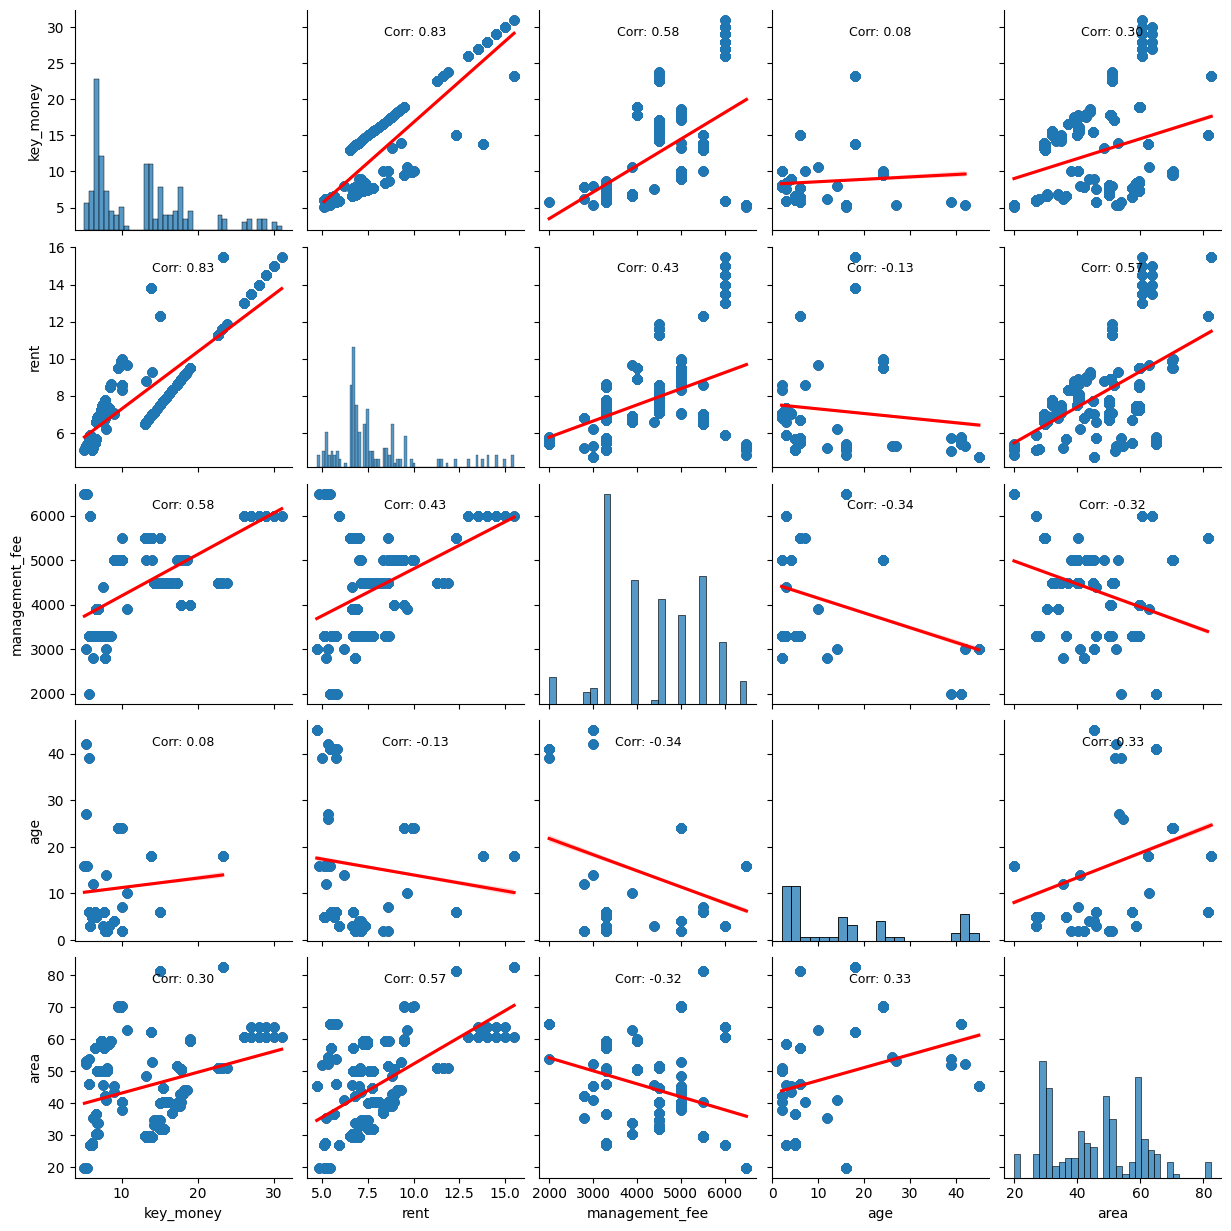

In [ ]:
# 数値型の列のみを含むデータフレームを作成
numeric_df = df[numeric_columns]

# 数値型の列が存在するか確認
if not numeric_df.empty:
    # ペアプロットを作成
    g = sns.pairplot(numeric_df[columns_to_convert], kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})

    # 相関行列を計算
    corr = numeric_df[columns_to_convert].corr()

    # グリッドにアノテーションを追加
    for i, col in enumerate(columns_to_convert):
        for j, row in enumerate(columns_to_convert):
            if i != j:
                # 相関係数を計算
                correlation = corr.loc[row, col]
                # 上部に相関係数を表示
                g.axes[j, i].annotate(f'Corr: {correlation:.2f}', (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=9)

    plt.show()
else:
    print("No numeric columns found in the dataframe.")

In [ ]:
# Count total number of property listings
total_listings = len(df)
print(f"Total number of property listings: {total_listings}")

Total number of property listings: 21300


##<font color=fbb03b>最小二乗法による回帰分析

In [ ]:
# 必要な列を選択
columns_to_use = ['key_money', 'rent', 'management_fee', 'age', 'area']
numeric_df_2 = df[columns_to_use]

# 欠損値の確認と処理
print("欠損値の数:")
print(numeric_df_2.isnull().sum())

# 欠損値を含む行を削除
numeric_df_2 = numeric_df_2.dropna()

# 異常値の確認（例：面積や家賃が0以下、築年数が負の値）
print("\n異常値の数:")
print((numeric_df_2['key_money'] < 0).sum(), "件の礼金が負の値")
print((numeric_df_2['rent'] <= 0).sum(), "件の家賃が0以下")
print((numeric_df_2['management_fee'] < 0).sum(), "件の管理費が負の値")
print((numeric_df_2['age'] < 0).sum(), "件の築年数が負の値")
print((numeric_df_2['area'] <= 0).sum(), "件の面積が0以下")

# 異常値を含む行を削除
numeric_df_2 = numeric_df_2[(numeric_df_2['key_money'] >= 0) & (numeric_df_2['rent'] > 0) & (numeric_df_2['management_fee'] >= 0) & (numeric_df_2['area'] > 0) & (numeric_df_2['age'] >= 0)]

# 説明変数と目的変数を設定
X = numeric_df_2[['key_money', 'management_fee', 'age', 'area']]
y = numeric_df_2['rent']

# スケーリング（オプション）
# X = (X - X.mean()) / X.std()

# 定数項を追加
X = sm.add_constant(X)

# モデルの構築
model = sm.OLS(y, X).fit()

# 結果の出力
print(model.summary())

# R風の出力形式
print("\nCall:")
print("lm(formula = rent ~ area + age)")

print("\nResiduals:")
residuals = model.resid
print(f"Min       1Q   Median       3Q      Max")
print(f"{residuals.min():.4f} {residuals.quantile(0.25):.4f} {residuals.median():.4f} {residuals.quantile(0.75):.4f} {residuals.max():.4f}")

print("\nCoefficients:")
coef = model.params
std_err = model.bse
t_values = model.tvalues
p_values = model.pvalues

print("            Estimate Std. Error t value Pr(>|t|)")
for name, c, se, t, p in zip(coef.index, coef, std_err, t_values, p_values):
    stars = ''
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    elif p < 0.1:
        stars = '.'
    print(f"{name:12} {c:.6f} {se:.6f} {t:.3f} {p:.6f} {stars}")

print("---")
print("Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

print(f"\nResidual standard error: {np.sqrt(model.mse_resid):.3f} on {model.df_resid} degrees of freedom")
print(f"Multiple R-squared: {model.rsquared:.4f}, Adjusted R-squared: {model.rsquared_adj:.4f}")
f_statistic = model.fvalue
f_p_value = model.f_pvalue
print(f"F-statistic: {f_statistic:.3f} on {model.df_model} and {model.df_resid} DF,  p-value: {f_p_value:.2e}")

欠損値の数:
key_money          1100
rent                  0
management_fee      700
age               15300
area                  0
dtype: int64

異常値の数:
0 件の礼金が負の値
0 件の家賃が0以下
0 件の管理費が負の値
0 件の築年数が負の値
0 件の面積が0以下
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 3.121e+04
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:42:16   Log-Likelihood:                -1653.0
No. Observations:                4400   AIC:                             3316.
Df Residuals:                    4395   BIC:                             3348.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
     

##<font color=fbb03b>回帰診断

KeyError: 55

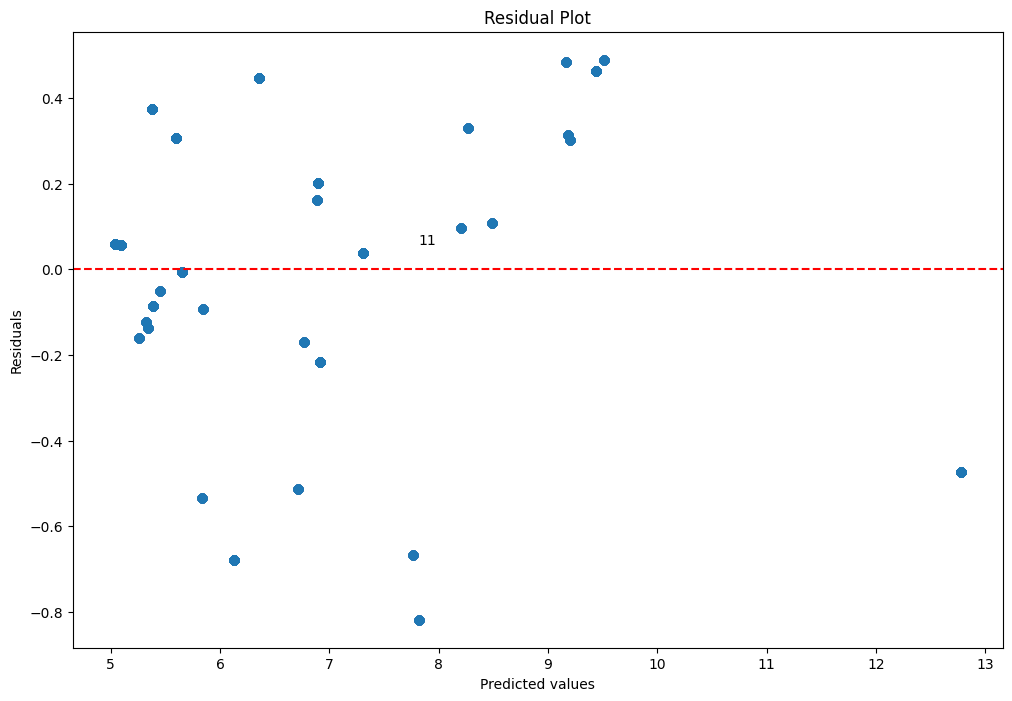

In [ ]:
# 残差、予測値、レバレッジ、影響度を計算
residuals = model.resid
predicted = model.predict()
leverage = model.get_influence().hat_matrix_diag
cooks_d = model.get_influence().cooks_distance[0]
std_residuals = model.get_influence().resid_studentized_internal

# 1. 残差プロット（外れ値にIDを付ける）
plt.figure(figsize=(12, 8))
plt.scatter(predicted, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

# 標準化残差が2以上または-2以下の点にIDを付ける
for i, std_resid in enumerate(std_residuals):
    if abs(std_resid) > 2:
        plt.annotate(i, (predicted[i], residuals[i]))

plt.show()

# 2. 正規Q-Qプロット
fig, ax = plt.subplots(figsize=(12, 8))
sm.qqplot(residuals, line='45', fit=True, ax=ax)
ax.set_title('Normal Q-Q Plot')
plt.show()

# 3. スケール-ロケーションプロット（標準化残差の絶対値の平方根プロット）
plt.figure(figsize=(12, 8))
plt.scatter(predicted, np.sqrt(np.abs(std_residuals)))
plt.xlabel('Predicted values')
plt.ylabel('Sqrt of |Standardized Residuals|')
plt.title('Scale-Location Plot')

# 標準化残差が2以上の点にIDを付ける
for i, std_resid in enumerate(std_residuals):
    if abs(std_resid) > 2:
        plt.annotate(i, (predicted[i], np.sqrt(abs(std_resid))))

plt.show()

# 4. Leverage vs Residuals Plot (with Cook's distance)
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(leverage, std_residuals, c=cooks_d, cmap='RdYlBu_r')
plt.colorbar(label="Cook's distance")
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs Residuals Plot')

# Cook's distanceの閾値を0.5に設定
cook_threshold = 0.5

# 影響度の強いポイントをハイライト
for i in range(len(X)):
    if cooks_d[i] > cook_threshold or abs(std_residuals[i]) > 2:
        ax.annotate(i, (leverage[i], std_residuals[i]))

plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 診断結果の要約
print("回帰診断の要約:")
print(f"1. 残差の平均: {residuals.mean():.4f}")
print(f"2. 残差の標準偏差: {residuals.std():.4f}")
print(f"3. 最大のCook's distance: {cooks_d.max():.4f}")
print(f"4. Cook's distanceが{cook_threshold:.1f}を超える（外れ値と考えられる）データポイントの数: {(cooks_d > cook_threshold).sum()}")
print(f"5. 標準化残差の絶対値が2を超えるデータポイントの数: {(np.abs(std_residuals) > 2).sum()}")

# 外れ値の詳細情報
outliers = df[(cooks_d > cook_threshold) | (np.abs(std_residuals) > 2)]
if not outliers.empty:
    print("\n外れ値の可能性がある点の詳細:")
    outliers['cook_d'] = cooks_d[(cooks_d > cook_threshold) | (np.abs(std_residuals) > 2)]
    outliers['std_residuals'] = std_residuals[(cooks_d > cook_threshold) | (np.abs(std_residuals) > 2)]
    print(outliers)
else:
    print("\n外れ値の可能性がある点は検出されませんでした。")

In [ ]:
df.head()

,category,building_name,address,access1,access2,access3,age,total_floors,floor,rent,management_fee,deposit,key_money,layout,area,url
0,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,2.0,5.45,3300.0,NaN,6.45,2LDK,57.21,https://suumo.jp/chintai/jnc_000090520648/?bc=...
1,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,1.0,5.75,3300.0,NaN,5.75,2DK,46.06,https://suumo.jp/chintai/jnc_000089647909/?bc=...
2,賃貸アパート,ヴィラ・グレイス久松台,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 バス18分 (バス停)木之庄上 歩11分,,6.0,2.0,2.0,6.70,3300.0,NaN,7.70,2LDK,57.19,https://suumo.jp/chintai/jnc_000091567682/?bc=...
3,賃貸マンション,ラ・ヴィ・アン・ローズ南本庄,広島県福山市南本庄３,ＪＲ福塩線/備後本庄駅 歩16分,ＪＲ山陽本線/福山駅 歩18分,,3.0,5.0,3.0,5.90,6000.0,NaN,5.90,1K,26.87,https://suumo.jp/chintai/jnc_000091567684/?bc=...
4,賃貸アパート,ＪＲ福塩線 備後本庄駅 2階建 築6年,広島県福山市久松台３,ＪＲ福塩線/備後本庄駅 歩19分,ＪＲ山陽本線/福山駅 歩28分,ＪＲ福塩線/横尾駅 歩68分,6.0,2.0,2.0,5.45,3300.0,NaN,6.45,2LDK,57.21,https://suumo.jp/chintai/jnc_000090513634/?bc=...


##<font color=fbb03b>結果となるデータの作成

In [ ]:
# 実際の物件情報から予測価格を計算
df['predicted_rent'] = model.predict(X)

# 差分（実際の賃料 - 予測価格）を計算
df['diff'] = df['rent'] - df['predicted_rent']

# 実際の賃料が予測価格よりも安い物件のみを抽出し、'building_name'で昇順にソートして新しいDataFrameを作成
reasonable_houses = df[df['diff'] < 0][['category', 'building_name', 'diff', 'rent', 'predicted_rent', 'address', 'age', 'floor', 'management_fee', 'deposit', 'key_money', 'layout', 'area', 'url']]
reasonable_houses_sorted = reasonable_houses.sort_values(by='building_name')
# 重複行のマージ
reasonable_houses_merged = reasonable_houses_sorted.drop_duplicates()

# 出力例の形式に合わせて表示
print(reasonable_houses_merged[['building_name', 'rent', 'predicted_rent', 'diff', 'url']])

              building_name   rent  predicted_rent      diff  \
6075               サンシャイン日吉   5.75        5.842128 -0.092128   
12381             セント・ローレンス   7.10        7.767623 -0.667623   
13658             セント・ローレンス   7.00        7.818685 -0.818685   
10794         フレッチェ・ボスコI（1）  12.30       12.774121 -0.474121   
19190                プルミエール   6.20        6.712632 -0.512632   
20639               ラフィネ　ドゥ   6.60        6.770295 -0.170295   
9539                  リオン　Ａ   5.65        5.655461 -0.005461   
15166               レオパレス大智   5.20        5.323649 -0.123649   
14102               レオパレス大智   5.30        5.386634 -0.086634   
2815                レオパレス大智   5.40        5.449619 -0.049619   
13890               レオパレス大智   5.30        5.386634 -0.086634   
2385                レオパレス大智   5.10        5.260665 -0.160665   
14058           ヴィラ・グレイス久松台   5.45        6.128644 -0.678644   
7457            ヴィラ・グレイス久松台   6.70        6.915394 -0.215394   
327                川口東マンション   5.30      

In [ ]:
# 全データ数を確認
total_data_count = df.shape[0]

# お得な物件数を確認
reasonable_houses_count = reasonable_houses_merged.shape[0]

print(f"Total number of data points in df: {total_data_count}")
print(f"Total number of reasonable houses: {reasonable_houses_count}")

Total number of data points in df: 21300
Total number of reasonable houses: 20


In [ ]:
# スプレッドシート形式のデータにエクスポートして保存
reasonable_houses_merged.to_csv('reasonable_houses_merged.csv', index=False, encoding='utf-8-sig')
print("Data has been exported to 'reasonable_houses_merged.csv'.")

Data has been exported to 'reasonable_houses_merged.csv'.


In [ ]:
# エクセル形式のデータにしてエクスポートして保存
reasonable_houses_merged.to_excel('reasonable_houses_merged.xlsx', index=False)
print("Data has been exported to 'reasonable_houses_merged.xlsx'.")

Data has been exported to 'reasonable_houses_merged.xlsx'.
